# Embedding Ratings
CSC 6711  
Nicholas Kaja  

### To Try:  
- ~~TFIDF~~
- Binary ratings (0/1 instead of 0-5)
- "Session-based" training

In [1]:
# TensorFlow Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

# Other
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')
tf.config.run_functions_eagerly(True)
#tf.data.experimental.enable_debug_mode()

## Classes and Methods

In [2]:
class EmbeddingRatings:
    def __init__(self, hidden_dim: int, k: int):
        input_vec = keras.Input(shape=(59047,))
        encoded = layers.Dense(hidden_dim, activation='relu')(input_vec)
        decoded = layers.Dense(59047, activation='sigmoid')(encoded)
        
        self.autoencoder = keras.Model(input_vec, decoded)
        self.encoder = keras.Model(input_vec, encoded)
        self.autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        
        self.knn = NearestNeighbors(metric='cosine', n_neighbors=k)
        #self.tfidf = TfidfTransformer()
    
    def fit(self, training_ratings: csr_matrix, epochs: int, batch_size: int):
        self.training_ratings = training_ratings
        
        # Divide by 5 to range ratings between 0-1 (works with sigmoid output)
        generator = SparseDataGenerator(self.training_ratings / 5, batch_size=batch_size)
        print('Fitting autoencoder...')
        self.autoencoder.fit(generator,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=True)
        
        print('Creating embeddings...')
        self.embeddings = self.encoder.predict(self.training_ratings / 5)
        self.knn.fit(self.embeddings)
        #self.knn.fit(self.tfidf.fit_transform(self.embeddings))
        
    def predict(self, user_ratings):
        print('Embedding test users...')
        pred_embeddings = self.encoder.predict(user_ratings / 5)
        
        print('Performing nearest-neighbor search in embedding space...')
        user_neighbors = self.knn.kneighbors(pred_embeddings, return_distance=False)
        #user_neighbors = self.knn.kneighbors(self.tfidf.transform(pred_embeddings), return_distance=False)
        
        print('Aggregating neighbor ratings...')
        pred = lil_matrix(user_ratings.shape)
        for idx, neighbor_indices in enumerate(user_neighbors):
            neighbors = self.training_ratings[neighbor_indices]
            divisor = neighbors.getnnz(axis=0)
            divisor[divisor == 0] = 1
            pred[idx] = neighbors.sum(axis=0) / divisor
 
        return pred.tocsr()

In [3]:
class SparseDataGenerator(keras.utils.Sequence):
    def __init__(self, x, batch_size):
        self.x = x
        self.batch_size = batch_size
        self.indices = np.arange(x.shape[0])

    def __len__(self):
        return int(np.ceil(self.x.shape[0] / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch = self.x[batch_indices].toarray()
        return batch, batch

In [4]:
def seen_unseen_split(ratings, fraction_seen=0.8):
    seen = lil_matrix(ratings.shape)
    unseen = lil_matrix(ratings.shape)

    for user_id in tqdm(range(ratings.shape[0])):
        rated_items_indices = ratings[user_id].nonzero()[1]
        np.random.shuffle(rated_items_indices)
        num_seen_items = int(fraction_seen * len(rated_items_indices))

        seen[user_id, rated_items_indices[:num_seen_items]] = ratings[user_id, rated_items_indices[:num_seen_items]]
        unseen[user_id, rated_items_indices[num_seen_items:]] = ratings[user_id, rated_items_indices[num_seen_items:]]

    return seen.tocsr(), unseen.tocsr()

## Data Preparation

In [5]:
df = pd.read_csv('ratings.csv').drop('timestamp', axis=1)
item_index = {item: index for index, item in enumerate(df['movieId'].unique())}

ratings_matrix = csr_matrix((df['rating'], (df['userId'] - 1, df['movieId'].map(item_index))),
                            shape=(len(df['userId'].unique()), len(item_index)))
del df

users_train, users_test = train_test_split(ratings_matrix, test_size=0.2)
del ratings_matrix

users_train.shape, users_test.shape

((130032, 59047), (32509, 59047))

In [6]:
seen, unseen = seen_unseen_split(users_test)

100%|██████████████████████████████████████████████████████████████████████████| 32509/32509 [00:15<00:00, 2070.64it/s]


## Usage

In [7]:
er = EmbeddingRatings(hidden_dim=128, k=200)

In [8]:
er.fit(users_train, epochs=10, batch_size=256)

Fitting autoencoder...
Epoch 1/10
508/508 [==============================] - 33s 64ms/step - loss: 0.0126
Epoch 2/10
508/508 [==============================] - 32s 64ms/step - loss: 0.0014
Epoch 3/10
508/508 [==============================] - 33s 64ms/step - loss: 0.0014
Epoch 4/10
508/508 [==============================] - 32s 64ms/step - loss: 0.0014
Epoch 5/10
508/508 [==============================] - 32s 64ms/step - loss: 0.0013
Epoch 6/10
508/508 [==============================] - 33s 65ms/step - loss: 0.0013
Epoch 7/10
508/508 [==============================] - 33s 65ms/step - loss: 0.0013
Epoch 8/10
508/508 [==============================] - 32s 64ms/step - loss: 0.0013
Epoch 9/10
508/508 [==============================] - 32s 64ms/step - loss: 0.0013
Epoch 10/10
508/508 [==============================] - 33s 64ms/step - loss: 0.0013
Creating embeddings...
4064/4064 [==============================] - 21s 5ms/step


In [9]:
er.embeddings.shape

(130032, 128)

In [10]:
pred = er.predict(seen)

Embedding test users...
1016/1016 [==============================] - 5s 5ms/step
Performing nearest-neighbor search in embedding space...
Aggregating neighbor ratings...


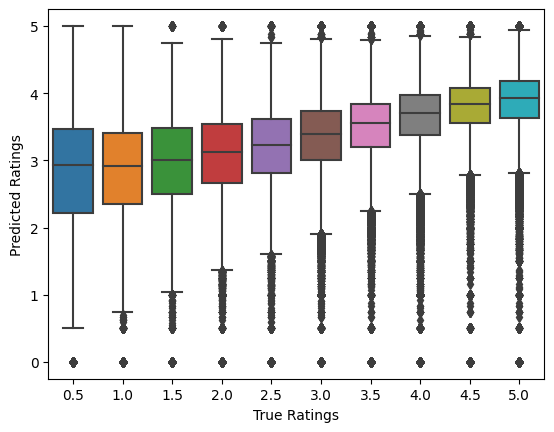

In [11]:
output = np.asarray(pred[unseen.nonzero()]).flatten() # Predictions lined up with unseen
sns.boxplot(x=unseen.data, y=output)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

*Previous Metrics*  
- hidden=128, k=200, epochs=10 > RMSE: 1.0690632384619443, R2: 0.1327474508966947
- hidden=128, k=200, epochs=10, TFIDF > RMSE: 1.0965591000702024, R2: 0.12109258734503982

In [12]:
RMSE = root_mean_squared_error(unseen.data, output)
correlation_coefficient, _ = pearsonr(unseen.data, output)
print(f"RMSE: {RMSE}\nR2: {correlation_coefficient ** 2}")

RMSE: 1.0965591000702024
R2: 0.12109258734503982


In [13]:
frac_nonzero_ratings = pred.nnz / np.prod(pred.shape)
frac_ratings_predicted = len(output.nonzero()[0]) / len(output)
print(f"Fraction Nonzero: {frac_nonzero_ratings}\nRecall (% unseen ratings predicted): {frac_ratings_predicted}")

Fraction Nonzero: 0.052101725975514636
Recall (% unseen ratings predicted): 0.9722587943142806


## Test Loop

In [7]:
rmses, r2s = [], []

In [8]:
epochs = 30
er = EmbeddingRatings(hidden_dim=512, k=200)
for i in range(epochs):
    er.fit(users_train, epochs=1, batch_size=256)
    pred = er.predict(seen)
    output = np.asarray(pred[unseen.nonzero()]).flatten() # Predictions lined up with unseen
    RMSE = root_mean_squared_error(unseen.data, output)
    correlation_coefficient, _ = pearsonr(unseen.data, output)
    print(f"Epoch {i + 1}:\n -RMSE: {RMSE}\n -R2: {correlation_coefficient ** 2}")
    rmses.append(RMSE)
    r2s.append(correlation_coefficient ** 2)

Fitting autoencoder...
508/508 [==============================] - 34s 63ms/step - loss: 0.0093
Creating embeddings...
4064/4064 [==============================] - 17s 4ms/step
Embedding test users...
1016/1016 [==============================] - 4s 4ms/step
Performing nearest-neighbor search in embedding space...
Aggregating neighbor ratings...
Epoch 1:
 -RMSE: 1.1128342735106336
 -R2: 0.11025981018778586
Fitting autoencoder...
508/508 [==============================] - 31s 61ms/step - loss: 0.0014
Creating embeddings...
4064/4064 [==============================] - 17s 4ms/step
Embedding test users...
1016/1016 [==============================] - 4s 4ms/step
Performing nearest-neighbor search in embedding space...
Aggregating neighbor ratings...
Epoch 2:
 -RMSE: 1.1134622428484764
 -R2: 0.11295807891522372
Fitting autoencoder...
508/508 [==============================] - 30s 59ms/step - loss: 0.0013
Creating embeddings...
4064/4064 [==============================] - 17s 4ms/step
Embeddin

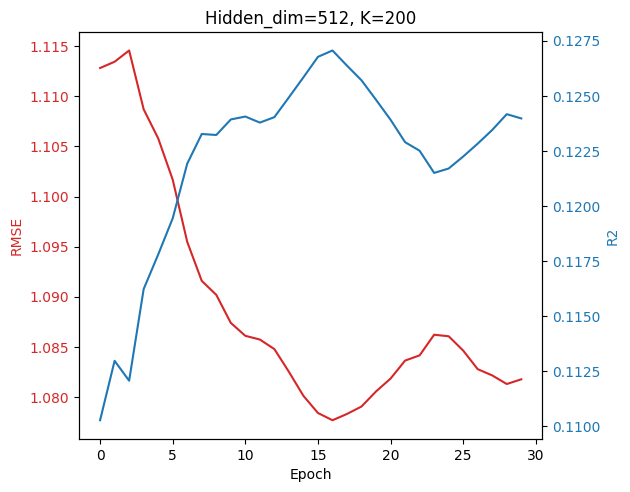

In [9]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('RMSE', color=color)
ax1.plot(range(len(rmses)), rmses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('R2', color=color)
ax2.plot(range(len(r2s)), r2s, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Hidden_dim=512, K=200')
plt.show()